In [40]:
import pandas as pd
import numpy as np
import sys
print(sys.path)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from numpy import argmax
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import pickle

['/home/magupta/anaconda3/envs/stackoverflow_env/RedHat', '/usr/lib64/python37.zip', '/usr/lib64/python3.7', '/usr/lib64/python3.7/lib-dynload', '', '/home/magupta/.local/lib/python3.7/site-packages', '/usr/local/lib64/python3.7/site-packages', '/usr/local/lib/python3.7/site-packages', '/usr/lib64/python3.7/site-packages', '/usr/lib/python3.7/site-packages', '/usr/local/lib/python3.7/site-packages/IPython/extensions', '/home/magupta/.ipython']


In [3]:
df_full=pd.read_csv("data_stackOverflow/final_dataframe_with_1tag_onehot.csv",index_col=0)
df_full.shape

/usr/local/lib64/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(1264212, 27)

In [4]:
label_col = [col for col in df_full if col.startswith('tag_')]
df_full.drop(label_col,inplace=True,axis=1)

In [5]:
df_full.head(2)

,ques_title,ques_body,ques_score_bad,ques_score_medium,ques_score_good,maintag,all_tags
0,sqlstatement execut multipl queri one statement,i written databas generat script href http en ...,0,0,1,other,other/other/other
1,good branch merg tutori tortoisesvn,realli good tutori explain href http svnbook r...,0,0,1,other,other/other/other/other


In [6]:
df_full["maintag"].value_counts()

other            424440
javascript       118826
java             114208
c#               100192
php               92015
android           71962
python            62622
c++               45318
ios               36617
jquery            31429
ruby-on-rails     22556
html              22276
sql               22094
mysql             20254
c                 18987
iphone            17165
asp.net           13329
css               11288
objective-c       10055
.net               8546
Name: maintag, dtype: int64

In [7]:
df_full.iloc[df_full['all_tags'].values=="nan/other/other/other"].head(2)

,ques_title,ques_body,ques_score_bad,ques_score_medium,ques_score_good,maintag,all_tags
33127,jsp portlet submit form valu,use liferay portal x deploy simpl portlet use ...,0,1,0,NaN,nan/other/other/other
154359,sitecor context item null postback,inherit sitecor implement tri debug membership...,0,0,1,NaN,nan/other/other/other


In [8]:
c=df_full['ques_title'].apply(lambda x: len(str(x).split()))
d=df_full['ques_body'].apply(lambda x: len(str(x).split()))
c.mean(),c.max(),c.min(),d.mean(),d.max(),d.min()

(5.79542197036573, 22, 1, 136.90592954346263, 8469, 1)

In [9]:
df_full['text']=df_full['ques_title']+df_full['ques_body']
df_full.drop(['ques_title','ques_body'],inplace=True,axis=1)

In [10]:
df_full = df_full[df_full.maintag.notnull()]
df_full.shape

(1264179, 6)

In [11]:
label_encoder = LabelEncoder() 
df_full['maintag']= label_encoder.fit_transform(df_full['maintag'].astype(str)) 
df_full['maintag'].unique() 

array([15, 19,  4,  5,  0,  7,  3,  2, 16, 10, 11,  6, 14, 13, 17, 18, 12,
        1,  9,  8])

In [12]:
label_encoder.classes_

array(['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'css', 'html',
       'ios', 'iphone', 'java', 'javascript', 'jquery', 'mysql',
       'objective-c', 'other', 'php', 'python', 'ruby-on-rails', 'sql'],
      dtype=object)

In [13]:
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
le_name_mapping

{'.net': 0,
 'android': 1,
 'asp.net': 2,
 'c': 3,
 'c#': 4,
 'c++': 5,
 'css': 6,
 'html': 7,
 'ios': 8,
 'iphone': 9,
 'java': 10,
 'javascript': 11,
 'jquery': 12,
 'mysql': 13,
 'objective-c': 14,
 'other': 15,
 'php': 16,
 'python': 17,
 'ruby-on-rails': 18,
 'sql': 19}

In [14]:
df_full.head(2)

,ques_score_bad,ques_score_medium,ques_score_good,maintag,all_tags,text
0,0,0,1,15,other/other/other,sqlstatement execut multipl queri one statemen...
1,0,0,1,15,other/other/other/other,good branch merg tutori tortoisesvnrealli good...


In [15]:
score_col = [col for col in df_full if col.startswith('ques_score_')]

# Applying tfidf

In [16]:
def tf_idf(df,flag,tfidf_text):
    if (flag=='train'):
        xyz = tfidf_text.fit_transform(df['text'].values.astype('U')).toarray().tolist()
    else:
        xyz = tfidf_text.transform(df['text'].values.astype('U')).toarray().tolist()
        
    return xyz

# Taking 5k samples from every class present in original dataframe

In [25]:
sample_size=5000
df_equal_samples=pd.DataFrame(df_full.groupby('maintag').apply(lambda x: x.sample(sample_size)))

In [26]:
equal_train, equal_val_test = train_test_split(df_equal_samples, test_size=0.2)
equal_val,equal_test=train_test_split(equal_val_test, test_size=0.5)

In [27]:
df_equal_samples.shape,equal_train.shape,equal_val.shape,equal_test.shape

((100000, 6), (80000, 6), (10000, 6), (10000, 6))

In [28]:
equal_x_train = equal_train.drop(['all_tags','maintag'],axis=1)
equal_x_val = equal_val.drop(['all_tags','maintag'],axis=1)
equal_x_test = equal_test.drop(['all_tags','maintag'],axis=1)
equal_y_train=equal_train['maintag']
equal_y_val=equal_val['maintag']
equal_y_test=equal_test['maintag']

In [29]:
equal_x_train.shape,equal_y_train.shape,equal_x_val.shape,equal_y_val.shape,equal_x_test.shape,equal_y_test.shape

((80000, 4), (80000,), (10000, 4), (10000,), (10000, 4), (10000,))

In [30]:
equal_x_train.columns

Index(['ques_score_bad', 'ques_score_medium', 'ques_score_good', 'text'], dtype='object')

In [31]:
equal_tfidf_text = TfidfVectorizer(lowercase=True,ngram_range=(1,3),max_features=300) # max_df=0.9, min_df=0.1

equal_train_tfidf = pd.DataFrame(tf_idf(equal_x_train,'train',equal_tfidf_text ))
equal_val_tfidf= pd.DataFrame(tf_idf(equal_x_val,'val',equal_tfidf_text ))
equal_test_tfidf=  pd.DataFrame(tf_idf(equal_x_test,'test',equal_tfidf_text ))

equal_train_features = pd.DataFrame(np.hstack([equal_train_tfidf, equal_x_train[score_col]]))
equal_val_features= pd.DataFrame(np.hstack([equal_val_tfidf, equal_x_val[score_col]]))
equal_test_features=  pd.DataFrame(np.hstack([equal_test_tfidf, equal_x_test[score_col]]))

In [43]:
len(equal_tfidf_text.vocabulary_)

NameError: name 'equal_tfidf_text' is not defined

In [33]:
print(equal_train_tfidf.shape,equal_val_tfidf.shape,equal_test_tfidf.shape)
print(equal_train_features.shape,equal_val_features.shape,equal_test_features.shape)

(80000, 300) (10000, 300) (10000, 300)
(80000, 303) (10000, 303) (10000, 303)


In [34]:
equal_text_feature_names = np.array(equal_tfidf_text.get_feature_names())

# Applying random Forest

In [35]:
model_1 = RandomForestClassifier(n_estimators=200, oob_score='TRUE', n_jobs=-1, random_state=50, max_features="auto",min_samples_leaf=1)
model_1.fit(equal_train_features, equal_y_train)
equal_y_pred = model_1.predict(equal_test_features)

In [36]:
print("accuracy of Random Forest:",accuracy_score(equal_y_pred,equal_y_test))

accuracy of Random Forest: 0.5758


In [37]:
conf_mat = confusion_matrix(equal_y_test, equal_y_pred)
print(conf_mat)

[[250   2  42   9  53  20   3   6   5  19  10  10   5   3  18  21   1   3
    2  26]
 [  5 382   1   1   6   3   1   3   5  33  15   1   0   2  12   5   2   2
    0   0]
 [ 27   0 311   1  33   2  12   7   3  18   3  10  11   3   3  12   1   2
    1  15]
 [  9   0   2 361   4  49   0   2   4   9   7   3   0   1  12  26   6  11
    1   5]
 [ 66   5  80  16 159  21   3  11  10  19  20   8   4   2  16  22   3   6
    2  15]
 [ 13   3   0 108   9 272   1   2   6  14   4   5   0   1  17  28   4   8
    0   0]
 [  5   2   3   3   0   0 324 143   5  13   1   8  17   0   2   3   5   0
    7   0]
 [  2   0  12   0   3   1 144 258   3  10   2  18  17   1   1   6  10   5
   10   3]
 [  4   4   5   8   3  11   1   1 265 100   4  11   1   1  91  11   2   6
    5   1]
 [  9   7   2  17   5  10   8   6 102 205   3   3   4   2  87  17   3   4
    1   9]
 [ 13  62   3  14  31  10   2   7   1  12 278   2   0   5   9  20   3   7
    3   7]
 [  1  13   8   7   8   4  15  49  11   8   5 200 138   0  12   9

In [38]:
report=classification_report(equal_y_test, equal_y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.54      0.49      0.51       508
           1       0.75      0.80      0.78       479
           2       0.60      0.65      0.62       475
           3       0.59      0.71      0.64       512
           4       0.43      0.33      0.37       488
           5       0.58      0.55      0.57       495
           6       0.59      0.60      0.59       541
           7       0.46      0.51      0.48       506
           8       0.48      0.50      0.49       535
           9       0.34      0.41      0.37       504
          10       0.70      0.57      0.63       489
          11       0.50      0.38      0.43       529
          12       0.61      0.72      0.66       486
          13       0.75      0.66      0.70       480
          14       0.37      0.39      0.38       483
          15       0.24      0.16      0.19       518
          16       0.74      0.70      0.72       511
          17       0.77    

# Taking Random 100k samples from original dataframe thus having stratified split.

In [17]:
df=df_full.sample(n=100000)
df['maintag'].value_counts()

15    33753
11     9509
10     8959
4      7897
16     7227
1      5759
17     5078
5      3527
8      2887
12     2375
7      1784
18     1752
19     1656
13     1614
3      1502
9      1367
2      1040
6       824
14      803
0       687
Name: maintag, dtype: int64

In [18]:
df.to_csv("sample_data.csv")

In [19]:
train, val_test = train_test_split(df, test_size=0.2)
val,test=train_test_split(val_test, test_size=0.5)

In [20]:
df.shape,train.shape,val.shape,test.shape

((100000, 6), (80000, 6), (10000, 6), (10000, 6))

In [21]:
df.columns

Index(['ques_score_bad', 'ques_score_medium', 'ques_score_good', 'maintag',
       'all_tags', 'text'],
      dtype='object')

In [22]:
x_train = train.drop(['all_tags','maintag'],axis=1)
x_val = val.drop(['all_tags','maintag'],axis=1)
x_test = test.drop(['all_tags','maintag'],axis=1)
y_train=train['maintag']
y_val=val['maintag']
y_test=test['maintag']

In [23]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape

((80000, 4), (80000,), (10000, 4), (10000,), (10000, 4), (10000,))

In [24]:
tfidf_text = TfidfVectorizer(lowercase=True,ngram_range=(1,3),max_features=500) # max_df=0.9, min_df=0.1

train_tfidf = pd.DataFrame(tf_idf(x_train,'train',tfidf_text))
val_tfidf= pd.DataFrame(tf_idf(x_val,'val',tfidf_text))
test_tfidf=  pd.DataFrame(tf_idf(x_test,'test',tfidf_text))

train_features = pd.DataFrame(np.hstack([train_tfidf, x_train[score_col]]))
val_features= pd.DataFrame(np.hstack([val_tfidf, x_val[score_col]]))
test_features=  pd.DataFrame(np.hstack([test_tfidf, x_test[score_col]]))

In [25]:
len(tfidf_text.vocabulary_)

500

In [26]:
print(train_tfidf.shape,val_tfidf.shape,test_tfidf.shape)
print(train_features.shape,val_features.shape,test_features.shape)

(80000, 500) (10000, 500) (10000, 500)
(80000, 503) (10000, 503) (10000, 503)


In [27]:
text_feature_names = np.array(tfidf_text.get_feature_names())

In [28]:
model_2 = RandomForestClassifier(n_estimators=100, oob_score='TRUE', n_jobs=-1, random_state=50, max_features="auto",min_samples_leaf=1)
model_2.fit(train_features, y_train)
y_pred = model_2.predict(test_features)

In [29]:
print("accuracy of Random Forest:",accuracy_score(y_pred,y_test))

accuracy of Random Forest: 0.6069


In [30]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[   0    0    0    0   16    0    1    0    0    0    1    1    0    0
     0   51    0    0    0    0]
 [   0  479    0    0    3    0    0    1    0    0   40    5    0    0
     0   93    1    1    0    0]
 [   0    0   14    0   23    0    0    2    0    0    0    6    0    1
     0   59    1    0    0    1]
 [   0    0    0   69    2   14    0    0    0    0    2    0    0    0
     0   73    1    3    0    0]
 [   0    1   12    0  316    3    0    1    0    0   23   20    3    4
     0  444    6    3    0    1]
 [   0    2    0   14    5  142    0    0    0    0    2    1    0    0
     0  161    0    3    0    0]
 [   0    0    0    0    0    1   12   21    0    0    0    9    0    0
     0   34    0    0    0    0]
 [   0    0    0    0    1    0    5   86    0    0    0   21    0    0
     0   71    9    0    1    0]
 [   0    3    0    1    1    0    0    0  106    0    0    1    0    0
     0  147    2    1    0    0]
 [   0    1    0    1    0    2    0    0   30    0    

In [31]:
report=classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.77      0.77      0.77       623
           2       0.40      0.13      0.20       107
           3       0.70      0.42      0.53       164
           4       0.66      0.38      0.48       837
           5       0.78      0.43      0.55       330
           6       0.52      0.16      0.24        77
           7       0.62      0.44      0.52       194
           8       0.56      0.40      0.47       262
           9       0.00      0.00      0.00       125
          10       0.71      0.58      0.64       919
          11       0.60      0.68      0.64       924
          12       0.56      0.22      0.31       236
          13       0.64      0.54      0.59       168
          14       0.00      0.00      0.00        65
          15       0.53      0.78      0.63      3328
          16       0.72      0.71      0.71       717
          17       0.81    

/usr/local/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 0, 'Relative Importance')

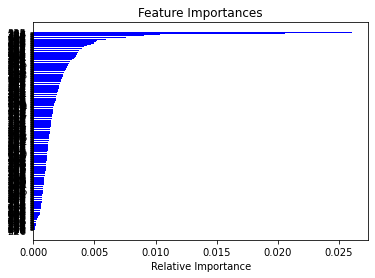

In [32]:
importances = model_2.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), train_features[indices])
plt.xlabel('Relative Importance')

In [33]:
importances={k: v for v, k in enumerate(importances)}
importances = dict([(value, key) for key, value in importances.items()]) 

In [34]:
text_dictn=tfidf_text.vocabulary_
feature_dict=dict([(value, key) for key, value in text_dictn.items()]) 

In [35]:
def mergeDict(dict1, dict2):
   ''' Merge dictionaries and keep values of common keys in list'''
   dict3 = {**dict1, **dict2}
   for key, value in dict3.items():
       if key in dict1 and key in dict2:
               dict3[key] = [value , dict1[key]]
 
   return dict3

In [36]:
final_dict=mergeDict(importances, feature_dict)
#final_dict

In [37]:
rem_list = [500, 501, 502] 
res = dict([(key, val) for key, val in 
           final_dict.items() if key not in rem_list]) 

In [38]:
listofTuples = sorted(res.items() , reverse=True, key=lambda x: x[1][1])

In [39]:
listofTuples[0:10]

[(335, ['php', 0.026087815527021108]),
 (14, ['android', 0.023758250673924706]),
 (224, ['java', 0.0213241506634514]),
 (363, ['python', 0.02063064279299344]),
 (227, ['javascript', 0.014087009775242973]),
 (230, ['jqueri', 0.010335043087206914]),
 (59, ['code', 0.010068408000823441]),
 (154, ['function', 0.009624995900247322]),
 (479, ['var', 0.009036939274172198]),
 (62, ['code pre', 0.008160413291616679])]

In [41]:
with open("feature_importance.txt", "wb") as fp:   #Pickling
    pickle.dump(listofTuples, fp)

In [42]:
pickle.dump(model_2, open('RF_model', 'wb'))

# Applying Xgboost on the dataset.

In [63]:
eval_set = [(train_features, y_train),(val_features, y_val)]
model_3 = XGBClassifier(learning_rate =0.1,n_estimators=100, max_depth=3,nthread=4,seed=27,objective="multi:softmax",num_class=20)

In [64]:
# n_estimators = range(50, 400, 50)
# param_grid = dict(n_estimators=n_estimators)
# kfold = StratifiedKFold(n_splits scoring="neg_log_loss", n_jobs=-1, cv=kfold)
# result = grid_search.fit(X, label_encoded_y)

In [ ]:
model_3.fit(train_features,y_train, eval_set=eval_set)
y_pred = model_3.predict(test_features)

[0]	validation_0-merror:0.44607	validation_1-merror:0.44070
[1]	validation_0-merror:0.44089	validation_1-merror:0.43450
[2]	validation_0-merror:0.44161	validation_1-merror:0.43730
[3]	validation_0-merror:0.43979	validation_1-merror:0.43360
[4]	validation_0-merror:0.43912	validation_1-merror:0.43500
[5]	validation_0-merror:0.43662	validation_1-merror:0.43300
[6]	validation_0-merror:0.43593	validation_1-merror:0.43190
[7]	validation_0-merror:0.43461	validation_1-merror:0.42990
[8]	validation_0-merror:0.43296	validation_1-merror:0.42960
[9]	validation_0-merror:0.43066	validation_1-merror:0.42810
[10]	validation_0-merror:0.42940	validation_1-merror:0.42690
[11]	validation_0-merror:0.42745	validation_1-merror:0.42500
[12]	validation_0-merror:0.42559	validation_1-merror:0.42420
[13]	validation_0-merror:0.42490	validation_1-merror:0.42390
[14]	validation_0-merror:0.42281	validation_1-merror:0.42080
[15]	validation_0-merror:0.42265	validation_1-merror:0.42140
[16]	validation_0-merror:0.42179	v

In [ ]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
print(confusion_matrix(y_test, y_pred))